# Build Neural Network definition from code

In this example we should how to build a `NetworkDefinition` directly from Python.

If you intend to use a model that is trained using a library like Keras, PyTorch, or Tensorflow you should look at the notebooks that show how to import models into OMLT.

## Library Setup

Start by importing the libraries used in this project:

 - `pyomo`: the algebraic modeling language for Python, it's used to define the optimization model passed to the solver
 - `numpy`: a general-purpose numerical library
 
We import the following classes from OMLT:

 - `OmltBlock`: a special type of Pyomo block that contains the variables and constraints of our machine-learning model
 - `NetworkDefinition`: class that contains the nodes in a Neural Network
 - `InputLayer`, `DenseLayer`: the two types of layers used in this example
 - `IndexTransformer`: used to reshape the data between layers

In [1]:
import pyomo.environ as pyo
import numpy as np

from omlt.block import OmltBlock
from omlt.neuralnet import NetworkDefinition, InputLayer, DenseLayer, ReLUBigMFormulation, IndexTransformer

## Neural Network creation

We start by creating the Neural Network definition. In this example, the input of the network is four variables in a 2 by 2 grid with bounds in $[-1, 1]$.

In [2]:
net = NetworkDefinition(input_bounds=[(-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0), (-1.0, 1.0)])

We can see that when the network is created it contains no layers.

In [3]:
list(net.nodes)

[]

We can now add the input layer. We specify that the input is a 2 by 2 matrix.

In [4]:
input_layer = InputLayer([2, 2])

Graphically, we represent the input layer as follows:

![input layer](../images/input-layer.png)


Notice the input has a double border since the input has dimension 2.

We then add the node to the layer

In [5]:
net.add_node(input_layer)

Now we add a dense layer to the network. A dense layer is a layer where each output node is connected to all input nodes. 

The output of the dense layer, before activation, is given by the following equation:

$$
Y = WX + b
$$

where $Y \in \mathbb{R}^{N \times L}$, $W \in \mathbb{R}^{N \times M}$, $X \in \mathbb{R}^{M \times L}$ and $b \in \mathbb{R}^N$.

In this case the activation function is linear which means that the output of the layer is $Y$.

A dense layer needs to know its input and output sizes to validate the size of the weights and biases.
In this example, the input is $X \in \mathbb{R}^{2 \times 2}$, the output is $Y \in \mathbb{R}^{2 \times 1}$, the weights are $W \in \mathbb{R}^{2 \times 1}$ and the biases are $b \in \mathbb{R}^2$.

Graphically, we represent this layer as follows:

![dense layer 0](../images/dense-layer-0.png)

In [6]:
dense_layer_0 = DenseLayer(
    input_size=input_layer.output_size,
    output_size=[2, 1],
    activation="linear",
    weights=np.array([[1.0], [-0.5]]),
    biases=np.array([[0.1], [0.25]])
)

We add the layer to the network and then connect the output of the input layer to the input of this layer.

In [7]:
net.add_node(dense_layer_0)
net.add_edge(input_layer, dense_layer_0)

In the final layer of our simple network we use a dense layer again. This time we want to "flatten" the output of the previous layer into a vector with the same number of elements.
We achieve this by defining an `IndexTransformer`. This object is used to map indices from differently-sized matrices, effectively changing the shape of the output of one layer to match the input of the other layer.

In [8]:
transformer = IndexTransformer([2, 1], [2])

for i in range(2):
    print(f"Input index {i} is output index {transformer([i])}")

Input index 0 is output index (0, 0)
Input index 1 is output index (1, 0)


This layer also uses a different type of activation function: the Rectified Linear Unit (ReLU) function. This function changes the output $Y$ of the layer to $Z$ defined as:

$$
Z = max(Y, 0)
$$

Graphically, the activation function looks like the following:

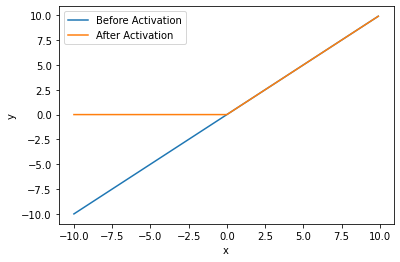

In [23]:
import matplotlib.pyplot as plt

x = np.arange(-10, 10, 0.1)
y = x
z = np.maximum(0, y)

plt.plot(x, y, label='Before Activation')
plt.plot(x, z, label='After Activation')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

We can now define the final dense layer, we specify `activation="relu"` to let OMLT know that the activation function of this layer is ReLU.

In [10]:
dense_layer_1 = DenseLayer(
    input_size=[2],
    output_size=[1],
    activation="relu",
    weights=np.array([2.0, -1.0]),
    biases=np.array([0.0]),
    input_index_transformer=transformer,
)

We can then connect the output of the previous dense layer (`dense_layer_0`) to the input of this dense layer (`dense_layer_1`).

In [11]:
net.add_node(dense_layer_1)
net.add_edge(dense_layer_0, dense_layer_1)

## Additional features

Layers provide a function `eval` to evaluate the layer with the given input. The input must be a numpy array of `layer.input_size` size.

We start by defining an input vector of the correct 2 by 2 size.

In [12]:
x = np.diag([1.0, 0.1]) + 0.3
x

array([[1.3, 0.3],
       [0.3, 0.4]])

The input layer simply returns the input as its output since it doesn't represent any operation.

In [13]:
x = input_layer.eval(x)
x

array([[1.3, 0.3],
       [0.3, 0.4]])

The first dense layer performs the $Y = WX + b$ operation. We notice that the output is a 2 by 1 numpy matrix.

In [14]:
x = dense_layer_0.eval(x)
x

array([[1.25],
       [0.35]])

The final dense layer perform the $Y = WX + B$ operation again, with different weights. The output is a vector with only one element.

In [15]:
x = dense_layer_1.eval(x)
x

array([2.15])

## Building the optimization model



In [16]:
m = pyo.ConcreteModel()
m.neural_net = OmltBlock()
formulation = ReLUBigMFormulation(net)
m.neural_net.build_formulation(formulation)

In [17]:
m.neural_net.inputs.pprint()

inputs : Size=4, Index=neural_net.inputs_set
    Key    : Lower : Value : Upper : Fixed : Stale : Domain
    (0, 0) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (0, 1) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (1, 0) :  -1.0 :     0 :   1.0 : False : False :  Reals
    (1, 1) :  -1.0 :     0 :   1.0 : False : False :  Reals


In [18]:
m.neural_net.outputs.pprint()

outputs : Size=1, Index=neural_net.outputs_set
    Key : Lower : Value : Upper : Fixed : Stale : Domain
      0 :  None :     0 :  None : False : False :  Reals


In [19]:
m.neural_net.layer[0].pprint()

{Member of layer} : Size=3, Index=neural_net.layer_index, Active=True
    neural_net.layer[0] : Active=True
        3 Set Declarations
            constraints_index : Size=1, Index=None, Ordered=Insertion
                Key  : Dimen : Domain : Size : Members
                None :     1 :    Any :    0 :      {}
            z_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     2 :    Any :    4 : {(0, 0), (0, 1), (1, 0), (1, 1)}
            zhat_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     2 :    Any :    4 : {(0, 0), (0, 1), (1, 0), (1, 1)}

        2 Var Declarations
            z : Size=4, Index=neural_net.layer[0].z_index
                Key    : Lower : Value : Upper : Fixed : Stale : Domain
                (0, 0) :  -1.0 :     0 :   1.0 : False : False :  Reals
                (0, 1) :  -1.0 :     0 :   1.0 : False : False :  Real

In [20]:
m.neural_net.layer[1].pprint()

{Member of layer} : Size=3, Index=neural_net.layer_index, Active=True
    neural_net.layer[1] : Active=True
        4 Set Declarations
            _linear_activation_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     2 :    Any :    2 : {(0, 0), (1, 0)}
            constraints_index : Size=1, Index=None, Ordered=Insertion
                Key  : Dimen : Domain : Size : Members
                None :     1 :    Any :    2 : {1, 2}
            z_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     2 :    Any :    2 : {(0, 0), (1, 0)}
            zhat_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     2 :    Any :    2 : {(0, 0), (1, 0)}

        2 Var Declarations
            z : Size=2, Index=neural_net.layer[1].z_index
                Key    : Lower  : Value : Upper : Fixed

In [21]:
m.neural_net.layer[2].pprint()

{Member of layer} : Size=3, Index=neural_net.layer_index, Active=True
    neural_net.layer[2] : Active=True
        10 Set Declarations
            _big_m_lb_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     1 :    Any :    1 :    {0,}
            _big_m_ub_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     1 :    Any :    1 :    {0,}
            _z_lower_bound_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     1 :    Any :    1 :    {0,}
            _z_lower_bound_zhat_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     1 :    Any :    1 :    {0,}
            _z_upper_bound_index : Size=1, Index=None, Ordered=False
                Key  : Dimen : Domain : Size : Members
                None :     1 